In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import torch
import torch.nn.functional as F
import pickle
import os
import itertools
import numpy as np
from rdkit.Chem import AllChem as Chem
from rdkit import Geometry
from openbabel import pybel
from openbabel import openbabel as ob
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [17]:
import sys
sys.path.append('..')
sys.path.append('../data_processing')

In [18]:
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated
from data_processing.utils import MAP_ATOMIC_NUMBER_TO_INDEX


In [19]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 600

In [20]:
root = '../evaluation/structure_based'

bridge_type = 'vp'
aromatic = False
optimization = False

In [21]:
ligand_name = '3ny8_A_rec_4ldo_ale_lig_tt_docked_4'

In [22]:
rec_mol_path = os.path.join(root, bridge_type, ligand_name, 'aromatic' if aromatic else 'basic')
rec_mol_path += '_optimized' if optimization else ''
gen_file = rec_mol_path + '.pkl'

rec_mol_path

'../evaluation/structure_based/vp/3ny8_A_rec_4ldo_ale_lig_tt_docked_4/basic'

In [23]:
with open(gen_file, 'rb') as f:
    gen_res = pickle.load(f)

In [24]:
bs = 10
i = 1

In [25]:
total_node = gen_res['x'].size(0)
assert total_node % bs == 0
num_node = int(total_node / bs)
assert num_node % 2 == 0
num_node

22

In [26]:
all_x = gen_res['x']
all_x.size()

torch.Size([220, 3])

In [27]:
x = gen_res['x'][num_node*i:num_node*(i+1)][:int(num_node/2)]
h = gen_res['h'][num_node*i:num_node*(i+1)][:int(num_node/2)]

In [28]:
h = F.softmax(h, dim=-1)
h

tensor([[0.0737, 0.1947, 0.0742, 0.0740, 0.0739, 0.0726, 0.0711, 0.0747, 0.0736,
         0.0739, 0.0712, 0.0724],
        [0.0736, 0.1947, 0.0742, 0.0739, 0.0740, 0.0727, 0.0711, 0.0747, 0.0736,
         0.0738, 0.0712, 0.0724],
        [0.0737, 0.1946, 0.0742, 0.0739, 0.0739, 0.0726, 0.0712, 0.0747, 0.0737,
         0.0739, 0.0711, 0.0724],
        [0.0738, 0.1948, 0.0742, 0.0740, 0.0738, 0.0727, 0.0711, 0.0747, 0.0736,
         0.0738, 0.0711, 0.0724],
        [0.0738, 0.1949, 0.0741, 0.0740, 0.0738, 0.0727, 0.0711, 0.0746, 0.0736,
         0.0739, 0.0711, 0.0724],
        [0.0737, 0.1949, 0.0742, 0.0739, 0.0739, 0.0726, 0.0711, 0.0746, 0.0737,
         0.0739, 0.0711, 0.0724],
        [0.0737, 0.0710, 0.0738, 0.0738, 0.2004, 0.0723, 0.0709, 0.0745, 0.0733,
         0.0735, 0.0708, 0.0721],
        [0.0738, 0.0709, 0.0737, 0.0736, 0.2006, 0.0722, 0.0709, 0.0745, 0.0733,
         0.0735, 0.0708, 0.0721],
        [0.0746, 0.0727, 0.0741, 0.1943, 0.0740, 0.0726, 0.0714, 0.0750, 0.0736,

In [29]:
h_class = torch.argmax(h, dim=-1)
atom_index = h_class.detach().cpu()
atom_index

tensor([1, 1, 1, 1, 1, 1, 4, 4, 3, 0, 4])

In [30]:
# why did I remove the last element in sample.py: reconstruct???
torch.argmax(h[:, :-1], dim=-1)

tensor([1, 1, 1, 1, 1, 1, 4, 4, 3, 0, 4])

In [31]:
if aromatic:
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
else:
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = None

In [32]:
atom_type, atom_aromatic

([6, 6, 6, 6, 6, 6, 8, 8, 7, 6, 8], None)

In [33]:
pos = x.tolist()
pos

[[-0.4784218668937683, -0.6253780722618103, 1.000860333442688],
 [-0.21282511949539185, 0.7936646342277527, 0.7914129495620728],
 [0.32370108366012573, -0.3416760265827179, -1.376934289932251],
 [-0.6502103805541992, -1.1411194801330566, 0.18925721943378448],
 [-0.39926114678382874, -1.0397614240646362, -0.9371545910835266],
 [0.9561530947685242, 0.5944390892982483, -0.7140491604804993],
 [-1.251038670539856, -2.037735939025879, 1.188822865486145],
 [-1.1035563945770264, -2.335238218307495, -1.551659345626831],
 [0.5753738284111023, 1.263214111328125, 0.4113801419734955],
 [1.0907254219055176, 2.1787238121032715, 1.040230631828308],
 [0.966397225856781, 3.101428985595703, 1.360795259475708]]

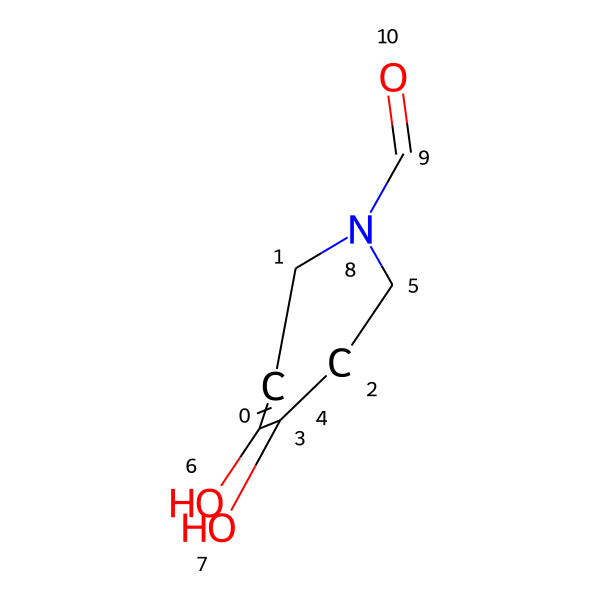

In [34]:
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic, basic_mode=False, covalent_factor=1.6)
mol

In [35]:
def make_obmol(xyz, atomic_numbers):
    mol = ob.OBMol()
    mol.BeginModify()
    atoms = []
    for xyz, t in zip(xyz, atomic_numbers):
        x, y, z = xyz
        # ch = struct.channels[t]
        atom = mol.NewAtom()
        atom.SetAtomicNum(t)
        atom.SetVector(x, y, z)
        atoms.append(atom)
    return mol, atoms

In [36]:
if aromatic:
    indicators = atom_aromatic
else:
    indicators = None

In [37]:
mol, atoms = make_obmol(pos, atom_type)

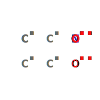

In [38]:
pbmol = pybel.Molecule(mol)
pbmol

In [39]:
def fixup(atoms, mol, indicators):
    '''Set atom properties to match channel.  Keep doing this
    to beat openbabel over the head with what we want to happen.'''

    """
    for now, indicators only include 'is_aromatic'
    """
    mol.SetAromaticPerceived(True)  # avoid perception
    for i, atom in enumerate(atoms):
        # ch = struct.channels[t]
        if indicators is not None:
            if indicators[i]:
                atom.SetAromatic(True)
                atom.SetHyb(2)
            else:
                atom.SetAromatic(False)

        # if ind[ATOM_FAMILIES_ID['Donor']]:
        #     if atom.GetExplicitDegree() == atom.GetHvyDegree():
        #         if atom.GetHvyDegree() == 1 and atom.GetAtomicNum() == 7:
        #             atom.SetImplicitHCount(2)
        #         else:
        #             atom.SetImplicitHCount(1) 

        # elif ind[ATOM_FAMILIES_ID['Acceptor']]: # NOT AcceptorDonor because of else
        #     atom.SetImplicitHCount(0)   

        if (atom.GetAtomicNum() in (7, 8)) and atom.IsInRing():  # Nitrogen, Oxygen
            # this is a little iffy, ommitting until there is more evidence it is a net positive
            # we don't have aromatic types for nitrogen, but if it
            # is in a ring with aromatic carbon mark it aromatic as well
            acnt = 0
            for nbr in ob.OBAtomAtomIter(atom):
                if nbr.IsAromatic():
                    acnt += 1
            if acnt > 1:
                atom.SetAromatic(True)

In [40]:
fixup(atoms, mol, indicators)

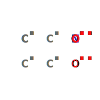

In [41]:
pbmol = pybel.Molecule(mol)
pbmol

In [42]:
def reachable_r(a, b, seenbonds):
    '''Recursive helper.'''

    for nbr in ob.OBAtomAtomIter(a):
        bond = a.GetBond(nbr).GetIdx()
        if bond not in seenbonds:
            seenbonds.add(bond)
            if nbr == b:
                return True
            elif reachable_r(nbr, b, seenbonds):
                return True
    return False


def reachable(a, b):
    '''Return true if atom b is reachable from a without using the bond between them.'''
    if a.GetExplicitDegree() == 1 or b.GetExplicitDegree() == 1:
        return False  # this is the _only_ bond for one atom
    # otherwise do recursive traversal
    seenbonds = set([a.GetBond(b).GetIdx()])
    return reachable_r(a, b, seenbonds)

def forms_small_angle(a, b, cutoff=60):
    '''Return true if bond between a and b is part of a small angle
    with a neighbor of a only.'''

    for nbr in ob.OBAtomAtomIter(a):
        if nbr != b:
            degrees = b.GetAngle(a, nbr)
            if degrees < cutoff:
                return True
    return False

In [43]:
def connect_the_dots(mol, atoms, indicators, covalent_factor=1.3):
    '''Custom implementation of ConnectTheDots.  This is similar to
    OpenBabel's version, but is more willing to make long bonds 
    (up to maxbond long) to keep the molecule connected.  It also 
    attempts to respect atom type information from struct.
    atoms and struct need to correspond in their order
    Assumes no hydrogens or existing bonds.
    '''

    """
    for now, indicators only include 'is_aromatic'
    """
    pt = Chem.GetPeriodicTable()

    if len(atoms) == 0:
        return

    mol.BeginModify()

    # just going to to do n^2 comparisons, can worry about efficiency later
    coords = np.array([(a.GetX(), a.GetY(), a.GetZ()) for a in atoms])
    dists = squareform(pdist(coords))
    # types = [struct.channels[t].name for t in struct.c]

    for i, j in itertools.combinations(range(len(atoms)), 2):
        a = atoms[i]
        b = atoms[j]
        a_r = ob.GetCovalentRad(a.GetAtomicNum()) * covalent_factor
        b_r = ob.GetCovalentRad(b.GetAtomicNum()) * covalent_factor
        if dists[i, j] < a_r + b_r:
            flag = 0
            if indicators and indicators[i] and indicators[j]:
                flag = ob.OB_AROMATIC_BOND
            mol.AddBond(a.GetIdx(), b.GetIdx(), 1, flag)

    atom_maxb = {}
    for (i, a) in enumerate(atoms):
        # set max valance to the smallest max allowed by openbabel or rdkit
        # since we want the molecule to be valid for both (rdkit is usually lower)
        maxb = min(ob.GetMaxBonds(a.GetAtomicNum()), pt.GetDefaultValence(a.GetAtomicNum()))

        if a.GetAtomicNum() == 16:  # sulfone check
            if count_nbrs_of_elem(a, 8) >= 2:
                maxb = 6

        # if indicators[i][ATOM_FAMILIES_ID['Donor']]:
        #     maxb -= 1 #leave room for hydrogen
        # if 'Donor' in types[i]:
        #     maxb -= 1 #leave room for hydrogen
        atom_maxb[a.GetIdx()] = maxb

    # remove any impossible bonds between halogens
    for bond in ob.OBMolBondIter(mol):
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()
        if atom_maxb[a1.GetIdx()] == 1 and atom_maxb[a2.GetIdx()] == 1:
            mol.DeleteBond(bond)

    def get_bond_info(biter):
        '''Return bonds sorted by their distortion'''
        bonds = [b for b in biter]
        binfo = []
        for bond in bonds:
            bdist = bond.GetLength()
            # compute how far away from optimal we are
            a1 = bond.GetBeginAtom()
            a2 = bond.GetEndAtom()
            ideal = ob.GetCovalentRad(a1.GetAtomicNum()) + ob.GetCovalentRad(a2.GetAtomicNum())
            stretch = bdist / ideal
            binfo.append((stretch, bond))
        binfo.sort(reverse=True, key=lambda t: t[0])  # most stretched bonds first
        return binfo

    binfo = get_bond_info(ob.OBMolBondIter(mol))
    # now eliminate geometrically poor bonds
    for stretch, bond in binfo:

        # can we remove this bond without disconnecting the molecule?
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()

        # as long as we aren't disconnecting, let's remove things
        # that are excessively far away (0.45 from ConnectTheDots)
        # get bonds to be less than max allowed
        # also remove tight angles, because that is what ConnectTheDots does
        if stretch > 1.2 or forms_small_angle(a1, a2) or forms_small_angle(a2, a1):
            # don't fragment the molecule
            if not reachable(a1, a2):
                continue
            mol.DeleteBond(bond)

    # prioritize removing hypervalency causing bonds, do more valent
    # constrained atoms first since their bonds introduce the most problems
    # with reachability (e.g. oxygen)
    hypers = [(atom_maxb[a.GetIdx()], a.GetExplicitValence() - atom_maxb[a.GetIdx()], a) for a in atoms]
    hypers = sorted(hypers, key=lambda aa: (aa[0], -aa[1]))
    for mb, diff, a in hypers:
        if a.GetExplicitValence() <= atom_maxb[a.GetIdx()]:
            continue
        binfo = get_bond_info(ob.OBAtomBondIter(a))
        for stretch, bond in binfo:

            if stretch < 0.9:  # the two atoms are too closed to remove the bond
                continue
            # can we remove this bond without disconnecting the molecule?
            a1 = bond.GetBeginAtom()
            a2 = bond.GetEndAtom()

            # get right valence
            if a1.GetExplicitValence() > atom_maxb[a1.GetIdx()] or a2.GetExplicitValence() > atom_maxb[a2.GetIdx()]:
                # don't fragment the molecule
                if not reachable(a1, a2):
                    continue
                mol.DeleteBond(bond)
                if a.GetExplicitValence() <= atom_maxb[a.GetIdx()]:
                    break  # let nbr atoms choose what bonds to throw out

    mol.EndModify()

In [44]:
connect_the_dots(mol, atoms, indicators, covalent_factor=1.3)
# fixup(atoms, mol, indicators)

# mol.ConnectTheDots()

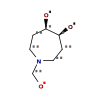

In [45]:
# pbmol = pybel.Molecule(mol)
pbmol

In [46]:
for atom in atoms:
    print(atom.IsAromatic())

False
False
False
False
False
False
False
False
False
False
False


False
False
False
False
False
False
False
False
False
False
False


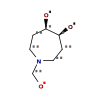

In [47]:
fixup(atoms, mol, indicators)
for atom in atoms:
    print(atom.IsAromatic())
pbmol

False
False
False
False
False
False
False
False
False
False
False


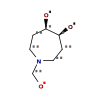

In [48]:
mol.AddPolarHydrogens()
for atom in atoms:
    print(atom.IsAromatic())
pbmol

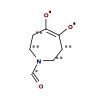

In [49]:
mol.PerceiveBondOrders()
pbmol

In [50]:
mol.PerceiveAromaticity()
pbmol

AttributeError: 'OBMol' object has no attribute 'PerceiveAromaticity'

False
False
False
False
False
False
False
False
False
False
False


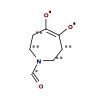

In [51]:
fixup(atoms, mol, indicators)
for atom in atoms:
    print(atom.IsAromatic())
pbmol

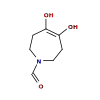

In [52]:
for (i, a) in enumerate(atoms):
    ob.OBAtomAssignTypicalImplicitHydrogens(a)
fixup(atoms, mol, indicators)
pbmol

In [53]:
for atom in atoms:
    print(atom.IsAromatic())

False
False
False
False
False
False
False
False
False
False
False


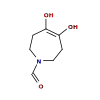

In [54]:
mol.AddHydrogens()
fixup(atoms, mol, indicators)
pbmol

In [55]:
for ring in ob.OBMolRingIter(mol):
    if 5 <= ring.Size() <= 6:
        carbon_cnt = 0
        aromatic_ccnt = 0
        for ai in ring._path:
            a = mol.GetAtom(ai)
            if a.GetAtomicNum() == 6:
                carbon_cnt += 1
                if a.IsAromatic():
                    aromatic_ccnt += 1
        if aromatic_ccnt >= carbon_cnt / 2 and aromatic_ccnt != ring.Size():
            # set all ring atoms to be aromatic
            for ai in ring._path:
                a = mol.GetAtom(ai)
                a.SetAromatic(True)

In [56]:
for atom in atoms:
    print(atom.IsAromatic())

False
False
False
False
False
False
False
False
False
False
False


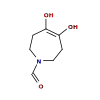

In [57]:
pbmol

In [58]:
for bond in ob.OBMolBondIter(mol):
    a1 = bond.GetBeginAtom()
    a2 = bond.GetEndAtom()
    if a1.IsAromatic() and a2.IsAromatic():
        bond.SetAromatic(True)

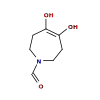

In [59]:
pbmol

In [60]:
# mol.PerceiveBondOrders()
# pbmol

In [61]:
def convert_ob_mol_to_rd_mol(ob_mol, struct=None):
    '''Convert OBMol to RDKit mol, fixing up issues'''
    ob_mol.DeleteHydrogens()
    n_atoms = ob_mol.NumAtoms()
    rd_mol = Chem.RWMol()
    rd_conf = Chem.Conformer(n_atoms)

    for ob_atom in ob.OBMolAtomIter(ob_mol):
        rd_atom = Chem.Atom(ob_atom.GetAtomicNum())
        # TODO copy format charge
        if ob_atom.IsAromatic() and ob_atom.IsInRing() and ob_atom.MemberOfRingSize() <= 6:
            # don't commit to being aromatic unless rdkit will be okay with the ring status
            # (this can happen if the atoms aren't fit well enough)
            rd_atom.SetIsAromatic(True)
        i = rd_mol.AddAtom(rd_atom)
        ob_coords = ob_atom.GetVector()
        x = ob_coords.GetX()
        y = ob_coords.GetY()
        z = ob_coords.GetZ()
        rd_coords = Geometry.Point3D(x, y, z)
        rd_conf.SetAtomPosition(i, rd_coords)

    rd_mol.AddConformer(rd_conf)

    for ob_bond in ob.OBMolBondIter(ob_mol):
        i = ob_bond.GetBeginAtomIdx() - 1
        j = ob_bond.GetEndAtomIdx() - 1
        bond_order = ob_bond.GetBondOrder()
        if bond_order == 1:
            rd_mol.AddBond(i, j, Chem.BondType.SINGLE)
        elif bond_order == 2:
            rd_mol.AddBond(i, j, Chem.BondType.DOUBLE)
        elif bond_order == 3:
            rd_mol.AddBond(i, j, Chem.BondType.TRIPLE)
        else:
            raise Exception('unknown bond order {}'.format(bond_order))

        if ob_bond.IsAromatic():
            bond = rd_mol.GetBondBetweenAtoms(i, j)
            bond.SetIsAromatic(True)

    rd_mol = Chem.RemoveHs(rd_mol, sanitize=False)

    pt = Chem.GetPeriodicTable()
    # if double/triple bonds are connected to hypervalent atoms, decrement the order

    positions = rd_mol.GetConformer().GetPositions()
    nonsingles = []
    for bond in rd_mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetBondType() == Chem.BondType.TRIPLE:
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            dist = np.linalg.norm(positions[i] - positions[j])
            nonsingles.append((dist, bond))
    nonsingles.sort(reverse=True, key=lambda t: t[0])

    for (d, bond) in nonsingles:
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()

        if calc_valence(a1) > pt.GetDefaultValence(a1.GetAtomicNum()) or \
                calc_valence(a2) > pt.GetDefaultValence(a2.GetAtomicNum()):
            btype = Chem.BondType.SINGLE
            if bond.GetBondType() == Chem.BondType.TRIPLE:
                btype = Chem.BondType.DOUBLE
            bond.SetBondType(btype)

    for atom in rd_mol.GetAtoms():
        # set nitrogens with 4 neighbors to have a charge
        if atom.GetAtomicNum() == 7 and atom.GetDegree() == 4:
            atom.SetFormalCharge(1)

    rd_mol = Chem.AddHs(rd_mol, addCoords=True)

    positions = rd_mol.GetConformer().GetPositions()
    center = np.mean(positions[np.all(np.isfinite(positions), axis=1)], axis=0)
    for atom in rd_mol.GetAtoms():
        i = atom.GetIdx()
        pos = positions[i]
        if not np.all(np.isfinite(pos)):
            # hydrogens on C fragment get set to nan (shouldn't, but they do)
            rd_mol.GetConformer().SetAtomPosition(i, center)

    try:
        Chem.SanitizeMol(rd_mol, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
    except:
        raise MolReconsError()
    # try:
    #     Chem.SanitizeMol(rd_mol,Chem.SANITIZE_ALL^Chem.SANITIZE_KEKULIZE)
    # except: # mtr22 - don't assume mols will pass this
    #     pass
    #     # dkoes - but we want to make failures as rare as possible and should debug them
    #     m = pybel.Molecule(ob_mol)
    #     i = np.random.randint(1000000)
    #     outname = 'bad%d.sdf'%i
    #     print("WRITING",outname)
    #     m.write('sdf',outname,overwrite=True)
    #     pickle.dump(struct,open('bad%d.pkl'%i,'wb'))

    # but at some point stop trying to enforce our aromaticity -
    # openbabel and rdkit have different aromaticity models so they
    # won't always agree.  Remove any aromatic bonds to non-aromatic atoms
    for bond in rd_mol.GetBonds():
        a1 = bond.GetBeginAtom()
        a2 = bond.GetEndAtom()
        if bond.GetIsAromatic():
            if not a1.GetIsAromatic() or not a2.GetIsAromatic():
                bond.SetIsAromatic(False)
        elif a1.GetIsAromatic() and a2.GetIsAromatic():
            bond.SetIsAromatic(True)

    return rd_mol

In [62]:
def calc_valence(rdatom):
    '''Can call GetExplicitValence before sanitize, but need to
    know this to fix up the molecule to prevent sanitization failures'''
    cnt = 0.0
    for bond in rdatom.GetBonds():
        cnt += bond.GetBondTypeAsDouble()
    return cnt


def count_nbrs_of_elem(atom, atomic_num):
    '''
    Count the number of neighbors atoms
    of atom with the given atomic_num.
    '''
    count = 0
    for nbr in ob.OBAtomAtomIter(atom):
        if nbr.GetAtomicNum() == atomic_num:
            count += 1
    return count

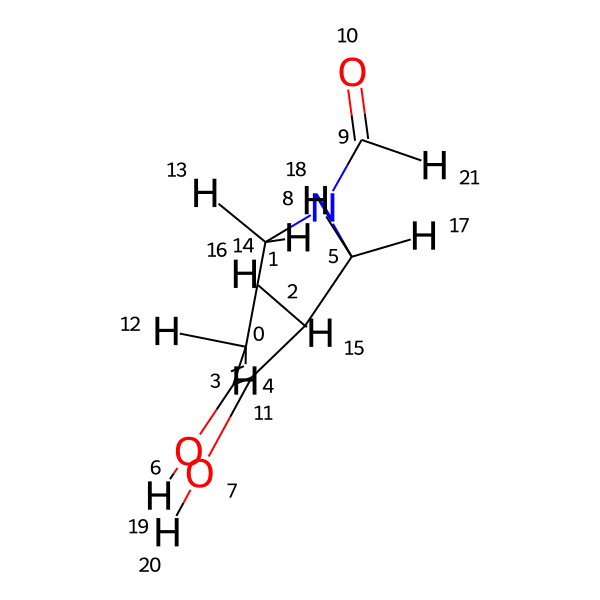

In [63]:
rd_mol = convert_ob_mol_to_rd_mol(mol)
rd_mol

In [64]:
UPGRADE_BOND_ORDER = {Chem.BondType.SINGLE: Chem.BondType.DOUBLE, Chem.BondType.DOUBLE: Chem.BondType.TRIPLE}


def postprocess_rd_mol_1(rdmol):
    rdmol = Chem.RemoveHs(rdmol)

    # Construct bond nbh list
    nbh_list = {}
    for bond in rdmol.GetBonds():
        begin, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if begin not in nbh_list:
            nbh_list[begin] = [end]
        else:
            nbh_list[begin].append(end)

        if end not in nbh_list:
            nbh_list[end] = [begin]
        else:
            nbh_list[end].append(begin)

    # Fix missing bond-order
    for atom in rdmol.GetAtoms():
        idx = atom.GetIdx()
        num_radical = atom.GetNumRadicalElectrons()
        if num_radical > 0:
            for j in nbh_list[idx]:
                if j <= idx: continue
                nb_atom = rdmol.GetAtomWithIdx(j)
                nb_radical = nb_atom.GetNumRadicalElectrons()
                if nb_radical > 0:
                    bond = rdmol.GetBondBetweenAtoms(idx, j)
                    bond.SetBondType(UPGRADE_BOND_ORDER[bond.GetBondType()])
                    nb_atom.SetNumRadicalElectrons(nb_radical - 1)
                    num_radical -= 1
            atom.SetNumRadicalElectrons(num_radical)

        num_radical = atom.GetNumRadicalElectrons()
        if num_radical > 0:
            atom.SetNumRadicalElectrons(0)
            num_hs = atom.GetNumExplicitHs()
            atom.SetNumExplicitHs(num_hs + num_radical)

    return rdmol


def postprocess_rd_mol_2(rdmol):
    rdmol_edit = Chem.RWMol(rdmol)

    ring_info = rdmol.GetRingInfo()
    ring_info.AtomRings()
    rings = [set(r) for r in ring_info.AtomRings()]
    for i, ring_a in enumerate(rings):
        if len(ring_a) == 3:
            non_carbon = []
            atom_by_symb = {}
            for atom_idx in ring_a:
                symb = rdmol.GetAtomWithIdx(atom_idx).GetSymbol()
                if symb != 'C':
                    non_carbon.append(atom_idx)
                if symb not in atom_by_symb:
                    atom_by_symb[symb] = [atom_idx]
                else:
                    atom_by_symb[symb].append(atom_idx)
            if len(non_carbon) == 2:
                rdmol_edit.RemoveBond(*non_carbon)
            if 'O' in atom_by_symb and len(atom_by_symb['O']) == 2:
                rdmol_edit.RemoveBond(*atom_by_symb['O'])
                rdmol_edit.GetAtomWithIdx(atom_by_symb['O'][0]).SetNumExplicitHs(
                    rdmol_edit.GetAtomWithIdx(atom_by_symb['O'][0]).GetNumExplicitHs() + 1
                )
                rdmol_edit.GetAtomWithIdx(atom_by_symb['O'][1]).SetNumExplicitHs(
                    rdmol_edit.GetAtomWithIdx(atom_by_symb['O'][1]).GetNumExplicitHs() + 1
                )
    rdmol = rdmol_edit.GetMol()

    for atom in rdmol.GetAtoms():
        if atom.GetFormalCharge() > 0:
            atom.SetFormalCharge(0)

    return rdmol

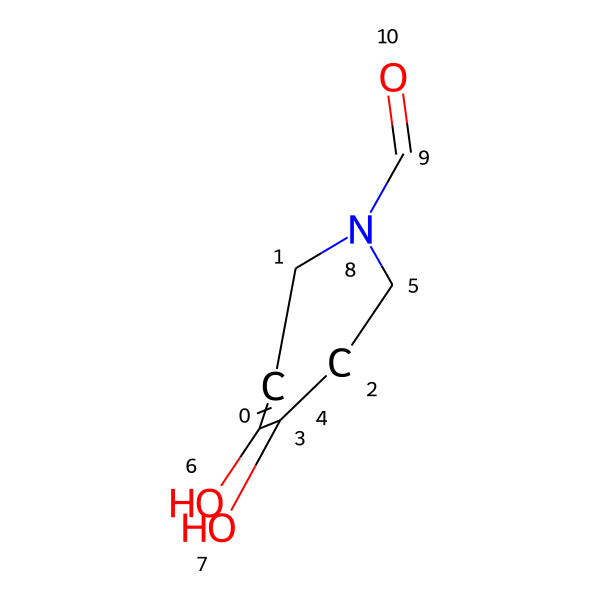

In [65]:
try:
    # Post-processing
    rd_mol = postprocess_rd_mol_1(rd_mol)
    rd_mol = postprocess_rd_mol_2(rd_mol)
except:
    raise MolReconsError()

rd_mol

In [67]:
ring = pbmol.sssr[0]
ring.IsAromatic()

IndexError: index out of range